cd### Imports

In [9]:
from datetime import datetime 
import os,inspect
import sys
import glob

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import scipy as sp
import scipy.sparse as sprs
from scipy.linalg import block_diag
import pandas as pd
import mpld3
mpld3.enable_notebook()
plt.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]
#plt.rcParams['figure.constrained_layout.use'] = True
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as mpatches
#from pathlib import Path
#print(Path.parent())
#print(os.pardir)
out_dir = os.path.join(os.path.dirname(os.getcwd()),'Figures')

def extract_date_time(path,format_filename,format_times):
	import re
	filename = os.path.basename(path)
	matchObj = re.match(format_filename, filename, re.M|re.I)
	time_stamps=[]
	for fmt_time,grp in zip(format_times,matchObj.groups()):
		time_stamps.append(datetime.strptime(grp,fmt_time))
	return time_stamps

#from pathlib import Path
#cwd = r'C:\Users\addalin\Dropbox\Lidar\code' #Path().resolve() # 
#sys.path.append(cwd)
from generate_atmosphere import LidarProfile,RadiosondeProfile
import miscLidar as mscLid
from molecular import rayleigh_scattering   #from lidar_molecular import molecular #from lidar_molecular.molecular import rayleigh_scattering  
from netCDF4 import Dataset

# constants
from global_settings import * #eps, c, h_plank, n_chan, min_height, CHANNELS, LAMBDA

n = 500  # number of measurements
top_height = 10 # [km]
heights = np.linspace(min_height, top_height, num=n)  # Measurements heights [Km]

### Molecular profiles
Generate backscatter and extinction molecular profiles from a radiosonde file (containing temperature and pressure measurements), based on Rayleigh scattering.

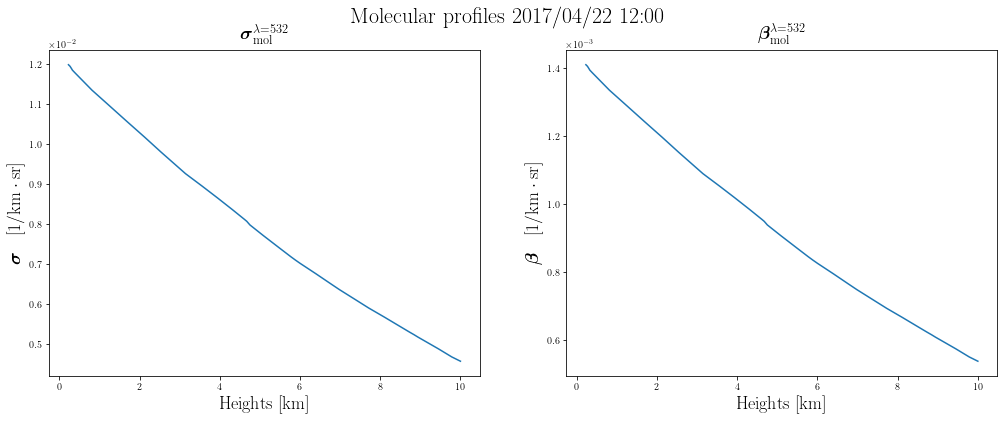

C:\Users\addalin\Dropbox\Lidar\Figures\Molecular profiles 2017-04-22 12_00.png


In [10]:
'''Read temperature and pressure from radiosounde file'''
soundePath = 'H:/data_haifa/Radiosonden/Haifa/2017/40179_20170422_12.txt'  # directory\stationNo_YYYYMMDD_hh.dat#
sounde_profile = RadiosondeProfile(soundePath)
temps = sounde_profile.interpolateKmKelvin(heights)     # Temprature [K]
pres = sounde_profile.interpolateKMPres(heights)        # Pressures [hPa]
relhs = sounde_profile.interpolateKMRLH(heights)        # Atmospheric relative humidity [%]
format_filename=  r'-(.*)_(.*)-(.*)-.*.txt'
time_stamp = extract_date_time(soundePath,r'40179_(.*).txt',['%Y%m%d_%H'])
stime= time_stamp[0].__format__('%Y/%m/%d %H:%M')
'''Calculating molecular profiles from temperature and pressure'''
lambda_um =  LAMBDA.G*1e+9  # convert wavelength units: from [m] to [nm].  
sigma_mol = rayleigh_scattering.alpha_rayleigh(wavelength = lambda_um, pressure=pres, temperature=temps, C=385., rh=relhs)*1e+3 # converting from [1/m] to [1/km] 
beta_mol = rayleigh_scattering.beta_pi_rayleigh(wavelength = lambda_um, pressure=pres, temperature=temps, C=385., rh=relhs)*1e+3 # converting from [1/m] to [1/km sr] 

'''Visualize molecular profiles''' 
vis_molecular = True 
save_fig = True
if vis_molecular:
    lData  = {'x':[heights],'y':[sigma_mol],'lableX': 'Heights [km]',
              'lableY': r"$\boldsymbol\sigma\quad[\rm 1/km\cdot sr]$",
              'stitle':r'$\boldsymbol\sigma_{{\rm mol}}^{{\lambda={0:.0f}}}$'.format(lambda_um)}
    rData  = {'x':[heights],'y':[beta_mol],'lableX': 'Heights [km]',
              'lableY': r'$\boldsymbol\beta\quad[\rm{{1}/{km\cdot sr}]}$',
              'stitle':r'$\boldsymbol\beta_{{\rm mol}}^{{\lambda={0:.0f}}}$'.format(lambda_um)}
    stitle= r'Molecular profiles {}'.format(stime)
    [fig, axes] = mscLid.visCurve(lData,rData,stitle)
    plt.show()
    if save_fig:
	    sfname = os.path.join(out_dir,stitle.replace('/','-').replace(':','_')+'.png')
	    print(sfname)
	    fig.savefig(sfname,bbox_inches='tight',dpi=700)

### Lidar Retrievals (from Tropos)
Read Lidar retrievals of Julian, and regenerate lidar measurements 
> ##### Note: this section assumes that the .nc file of the original measurements doesn't exists. 

In [11]:
retrivals_path = "./2017_04_22/*21smooth.txt"
lidar_paths = sorted(glob.glob(retrivals_path))[:4] 
lidar_df = pd.read_csv(lidar_paths[0],delimiter="\t",sep=" ",encoding='unicode_escape', 
		                       skiprows=None)
#lidar_df#.keys()
#lidar_df#["partdepolh"]#["Beta532 (Mm^-1 sr^-1):"]#[22:28]
#print(lidar_df.index.values)

### Regenerate Lidar power and the Logarithmic range adjusted power
> Notes:
>   1. The Lidar ratio, $b=55[\rm sr]$, and Lidar factor, $P_0a\frac{c\tau}{2}\approx 1.22+13$,
> were taken from Tropos retrieval of the shown time.
>   2. The Lidar factor, in reality, is not constant, nigher known. It changes through time. E.g, it degrades after the change of the lamp, 
>and dirt/dust on the covering glass affects as well on it's effective value. 
>Therefore it should be recalculated every time for retrieving profiles. 

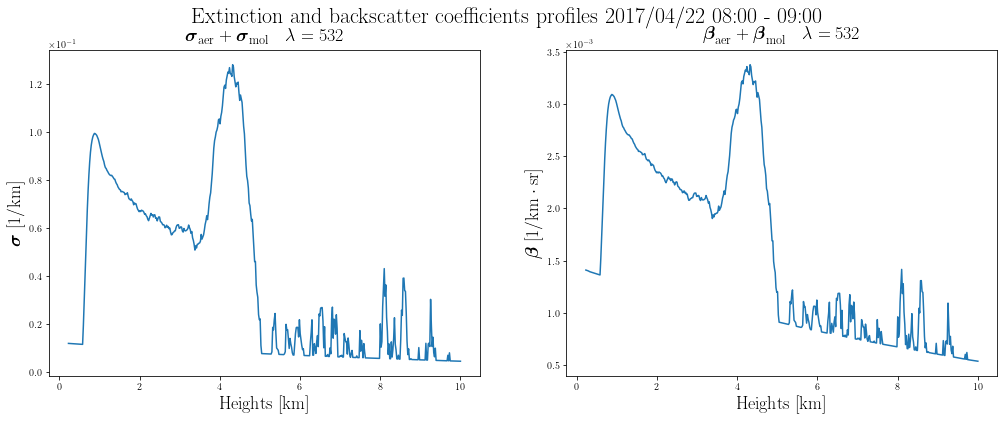

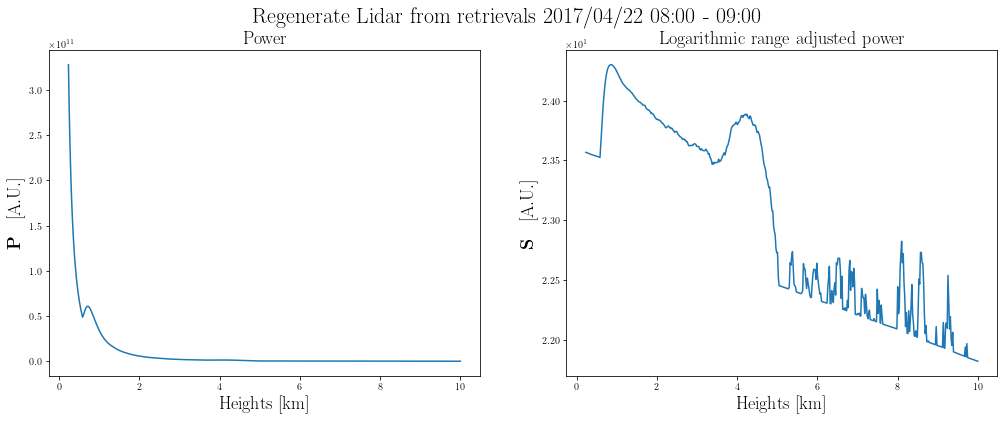

Regenerate Lidar from retrievals 2017/04/22 08:00 - 09:00


In [12]:
''' Load Lidar profiles from 22/4/17'''
retrivals_path = "./2017_04_22/*21smooth.txt"
lidar_paths = sorted(glob.glob(retrivals_path))[:1] 
profiles_sigma = []
profiles_beta = []
for path in lidar_paths:
    lidar_profile = LidarProfile(path)
    #min_height = lidar_profile._lidar_height
    #heights = np.linspace(min_height, top_meas_height, num = n) # num =1334 # num=100
    cur_profiles_0 = lidar_profile.interpolate(heights)[0] # TODO: Make sure - non negativity of retrieved values
    cur_profiles_1 = lidar_profile.interpolate(heights)[1] # TODO: Make sure - non negativity of retrieved values
    profiles_sigma.append(cur_profiles_0)
    profiles_beta.append(cur_profiles_1)
    time_stamps = extract_date_time(path,r'-(.*)_(.*)-(.*)-.*.txt', ['%Y%m%d','%H%M','%H%M'])
	
#print (lidar_paths)
#print(time_stamps)

stime='{} {} - {}'.format(time_stamps[0].date().__format__('%Y/%m/%d'),
                          time_stamps[1].time().__format__('%H:%M'),
                          time_stamps[2].time().__format__('%H:%M'))

#print(stime)
                        
''' Total profiles values of beta and sigma : molecular + aerosol '''
beta_aer_orig = profiles_beta[0]  # [1/km sr] #>Note: Channels [0] is for 8:00-9:00 
sigma_aer_orig = profiles_sigma[0] # [1/km]
betaT_orig = beta_aer_orig  + beta_mol 
sigmaT_orig = sigma_aer_orig + sigma_mol 
B_0 = 50    # [sr] #Value from Tropos retrieval (S in ...info.txt) - Lidar ratio . The value is taken from -20170422_0800-0900-41smooth-info.txt the lidar ratio for UV,G,IR is 55
b = 1./B_0

'''visualise sigma and molecular'''
vis_orig=True
if vis_orig:
	lData  = {'x':[heights],'y':[sigmaT_orig],'lableX': 'Heights [km]',
	          'lableY': r'$\boldsymbol\sigma\;{\rm [1/km]}$',
	          'stitle':r'$\boldsymbol\sigma_{{\rm aer}}+\boldsymbol\sigma_{{\rm mol}}\quad {{\lambda={0:.0f}}}$'.format(lambda_um)}
	rData  = {'x':[heights],'y':[betaT_orig],'lableX': 'Heights [km]',
	          'lableY': r'$\boldsymbol\beta\;{\rm [1/km \cdot sr]}$',
	          'stitle':r'$\boldsymbol\beta_{{\rm aer}}+\boldsymbol\beta_{{\rm mol}}\quad {{\lambda={0:.0f}}}$'.format(lambda_um)}
	stitle= 'Extinction and backscatter coefficients profiles {}'.format(stime)
	[fig2, axes2] = mscLid.visCurve(lData,rData,stitle)
	plt.show()
	if save_fig: 
		sfname = os.path.join(out_dir,stitle.replace('/','-').replace(':','_')+'.png')
		fig2.savefig(sfname,bbox_inches='tight',dpi=700)


'''Lidar constant. Note that A,P0,tau here are estimated. 
The lidar_const value should be be calculated following Rayleigh fit'''
tau = 50e-9 # [sec] temporal pulse width of the lidar
A = 1       # [km]  # TODO : ask for this value 
P0 = 1e+15   # TODO : ask for this value 
lidar_const= 1.219615E+13 # The value is from Tropos retrieval (Lidar constants in ...info.txt) # 7.49E+12#  # #lidar_const_optimized #1e+13# lidar_const_optimized#1e+13 #lidar_const_optimized #1e+13 #lidar_const_optimized
'''Calculate the power and the Logarithmic range adjusted power'''
P = mscLid.generate_P(P0,c,A,tau,heights,sigmaT_orig,betaT_orig,lidar_const) #TODO: Add noise to the signal regeneration. 
P = P.round()
P[P<np.finfo(np.float).eps] = np.finfo(np.float).eps
S = mscLid.calc_S(heights,P)

'''Visualize the power and the Logarithmic range adjusted power'''
vis_power=True
if vis_power:
    lData  = {'x':[heights],'y':[P],'lableX': 'Heights [km]',
              'lableY': r'$\boldsymbol{\rm P}\quad[\rm A.U.]$',
              'stitle':r'Power'}
    rData  = {'x':[heights],'y':[S],'lableX': 'Heights [km]',
              'lableY': r'$\boldsymbol{\rm S}\quad[\rm A.U.]$',
              'stitle':r'Logarithmic range adjusted power'}
    stitle= 'Regenerate Lidar from retrievals {}'.format(stime)
    [fig1, axes1] = mscLid.visCurve(lData,rData,stitle)
    plt.show()
    if save_fig:
	    print(stitle)
	    sfname = os.path.join(out_dir,stitle.replace('/','-').replace(':','_')+'.png')
	    fig1.savefig(sfname,bbox_inches='tight',dpi=700)
    

### KLETT retrieval
Calculate and show the inversion of the extinction and backscatter coefficients based on KLETT method, from the regenerated Lidar power. 
> Notes: 
>   1. The following Klett solution assumes known reference rage $r_m$ and lidar ratio $b$ (taken from TROPOS lidar retrieval solution), and the fitting coefficient is $k=1$ (a guess).
>   2. The Lidar ratio, $\frac{1}{b}=55[\rm sr]$ (for Saharan dust) $\forall\; r \in [0,10\rm km]$. $\rightarrow$ In reality this value variates with height, and also should have a better estimation.   

In [13]:
print (heights[300])

6.10334869739479


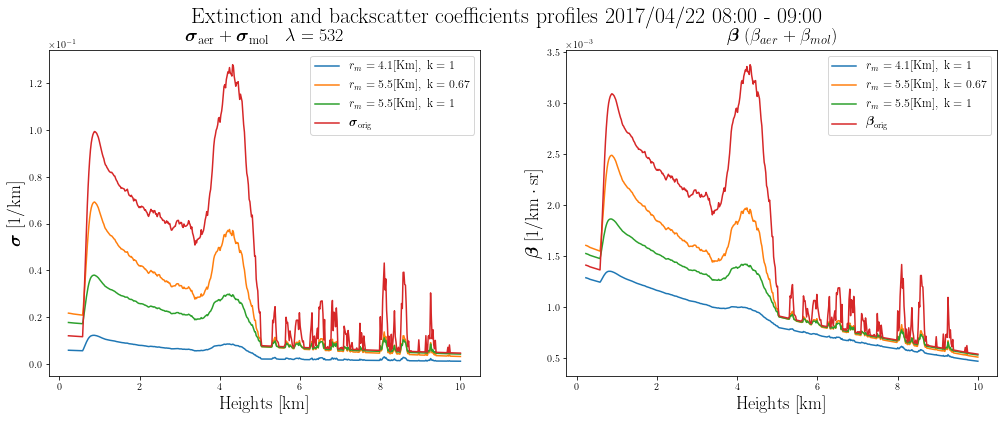

Extinction and backscatter coefficients profiles 2017/04/22 08:00 - 09:00


In [14]:
'''Calc Klett'''
#ind_m = 49#49#10 #49   # How to set the height rm and the values Sm ?? 46-49 doesn't work
n = len(heights)

ind_m =200# [200,300,300]
k = 1 #k is a fitting coefficient 0.67<k<1 (this is unknown in reality)
sigma_klett1 = mscLid.calc_extiction_klett(S, heights, sigma_mol, ind_m,k)
beta_klett1 = b*(sigma_klett1-sigma_mol) + beta_mol #b*np.power(sigma_r,k)
legend_sigma_1 = r'$r_m = {:.1f}[\rm Km],\;k={}$'.format(heights[ind_m],k) #r'$\boldsymbol\sigma_{{\rm Klett}},\;r_m = {:.1f}[\rm Km],\;k={}$'.format(heights[ind_m],k)
legend_beta_1 = r'$r_m = {:.1f}[\rm Km],\;k={}$'.format(heights[ind_m],k) #r'$\boldsymbol\beta_{{\rm Klett}},\;r_m = {:.1f}[\rm Km],\;k={}$'.format(heights[ind_m],k)

ind_m =270# [200,300,300]
k = 0.67 #k is a fitting coefficient 0.67<k<1 (this is unknown in reality)
sigma_klett2 = mscLid.calc_extiction_klett(S, heights, sigma_mol, ind_m,k)
beta_klett2 = b*(sigma_klett2-sigma_mol) + beta_mol #b*np.power(sigma_r,k)
legend_sigma_2 = r'$r_m = {:.1f}[\rm Km],\;k={}$'.format(heights[ind_m],k) #r'$\boldsymbol\sigma_{{\rm Klett}},\;r_m = {:.1f}[\rm Km],\;k={}$'.format(heights[ind_m],k)
legend_beta_2 = r'$r_m = {:.1f}[\rm Km],\;k={}$'.format(heights[ind_m],k) #r'$\boldsymbol\beta_{{\rm Klett}},\;r_m = {:.1f}[\rm Km],\;k={}$'.format(heights[ind_m],k)

ind_m =270# [200,300,300]
k = 1 #k is a fitting coefficient 0.67<k<1 (this is unknown in reality)
sigma_klett = mscLid.calc_extiction_klett(S, heights, sigma_mol, ind_m,k)
beta_klett = b*(sigma_klett-sigma_mol) + beta_mol #b*np.power(sigma_r,k)
legend_sigma = r'$r_m = {:.1f}[\rm Km],\;k={}$'.format(heights[ind_m],k) #r'$\boldsymbol\sigma_{{\rm Klett}},\;r_m = {:.1f}[\rm Km],\;k={}$'.format(heights[ind_m],k)
legend_beta = r'$r_m = {:.1f}[\rm Km],\;k={}$'.format(heights[ind_m],k) #r'$\boldsymbol\beta_{{\rm Klett}},\;r_m = {:.1f}[\rm Km],\;k={}$'.format(heights[ind_m],k)


'''Visualize Klett'''
vis_klett=True
if vis_klett:
	lData  = {'x':[heights, heights,heights,heights],'y':[sigma_klett1,sigma_klett2,sigma_klett,sigmaT_orig],'lableX': 'Heights [km]',
	          'lableY': r'$\boldsymbol\sigma\;{\rm [1/km]}$',
	          'stitle':r'$\boldsymbol\sigma_{{\rm aer}}+\boldsymbol\sigma_{{\rm mol}}\quad {{\lambda={0:.0f}}}$'.format(lambda_um),
	          'legend':[legend_sigma_1,legend_sigma_2,legend_sigma, r'$\boldsymbol\sigma_{\rm orig}$']}
	rData  = {'x':[heights, heights,heights,heights],'y':[beta_klett1,beta_klett2,beta_klett,betaT_orig],'lableX': 'Heights [km]',
	          'lableY': r'$\boldsymbol\beta\;{\rm [1/km \cdot sr]}$',
	          'stitle':r'$\boldsymbol\beta\;(\beta_{aer}+\beta_{mol})$',
	          'legend':[legend_beta_1,legend_beta_2,legend_beta,r'$\boldsymbol\beta_{\rm orig}$']}
	stitle= 'Extinction and backscatter coefficients profiles {}'.format(stime)
	[fig2, axes2] = mscLid.visCurve(lData,rData,stitle)
	plt.show()
	if save_fig:
		print(stitle)
		sfname = os.path.join(out_dir,stitle.replace('/','-').replace(':','_')+'.png')
		fig2.savefig(sfname,bbox_inches='tight',dpi=700)

In [15]:
heights[ind_m]

5.515913827655311

  
### Regularized Iterative LS 

0.0025444940723944997
epoch 0, loss Ls1 5.386555830056371e-05
epoch 2, loss LS1 1.3963334145480464e-08, df 5.013807194777647e-07
epoch 8, loss LS1 8.560518389861618e-11, df -9.822486817810128e-16
Regularized Iterative LS


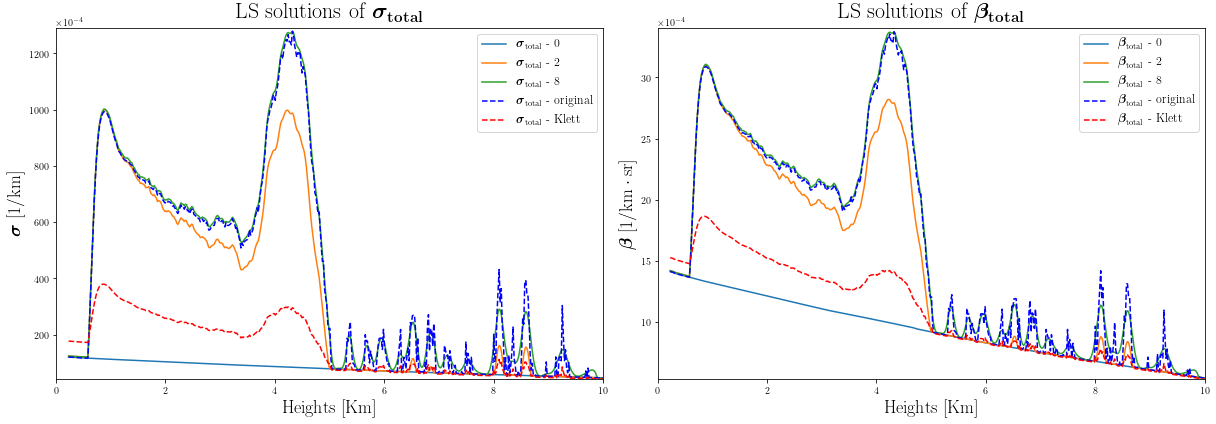

'\nP_mol = lidar_const*beta_mol*np.exp(-2 * np.cumsum(sigma_mol * dr))/(np.power(heights, 2) + eps)\nfig1= plt.figure()\nplt.plot(heights,P_mol)\nS_mol = mscLid.calc_S(heights,P_mol)\nkl_div = P*np.log(P/P_mol)\nfig2= plt.figure()\nplt.plot(kl_div)\n\n#kl_div[ind_m]\nprint(np.sum(kl_div))\nprint(lidar_const)\n\n# %%\n!cwd\n'

In [16]:
'''Create model matrices and functions'''
dr = np.mean(heights[1:]-heights[0:-1]) # dr for integration
D = dr*np.tril(np.ones((n,n)),0)
D[:,0] = heights[0]
D2 = -2*D
D2_inv = np.linalg.inv(D2)
rr =  np.power(heights,2) 
RR = np.diagflat(rr)
Q = np.linalg.inv(RR)

phi = lambda U_vec,D_mat:  np.exp(np.matmul(D_mat,U_vec))

## %% Solve regularized iterative LS 

'''set optimization flags and parameters'''
add_noise = False
WLS = False
add_Reg = True #False
lambda_reg = 0.125*0.125*0.125#2/2000.0
th_df = 10*eps    # The treshold value of l2 error differences (df) bewtween iterations 
max_iters = 10

''' set input measurments, and initial solution'''
ind_m = np.int(50*n/100.0) #+128

if add_noise:
    # add noise to p
    stdPowerNoise = np.sqrt(P)
    PNoise = np.random.normal(loc=P, scale=stdPowerNoise, size=n)
    PNoise= PNoise.round()
    PNoise[PNoise<eps] = eps
    #std_read_noise = 0
    #poissonNoise = np.random.poisson(P).astype(float)
    #PNoise =P +  stdPowerNoise*np.random.randn(n)
    
    # set normalize mesurments - y
    Y = PNoise/lidar_const
    
    # set initial solution sigma_0
    SNoise = mscLid.calc_S(heights,PNoise)
    sigmaT_0 = mscLid.calc_extiction_klett(SNoise, heights, sigma_mol, ind_m) # TODO - the value of sigma_m should be actualy taken from the molecular profile
    #sigma_0 = 0.1*np.ones_like(Y)
    if WLS: 
        var_noise = P/(lidar_const**2)
        W = np.diag(1/var_noise)
        Ws = np.sqrt(W)
        
else:
    # set normalize mesurments - y
    Y = P/lidar_const
    # set initial solution sigma_0
    S = mscLid.calc_S(heights,P)
    #sigmaT_0 = mscLid.calc_extiction_klett(S, heights, sigmaT_orig, ind_m) 
    #sigma_0= U_sol1
    sigmaT_0 = sigma_mol #0.1*np.ones_like(Y)
    #sigma_0 = U_sol_interp

'''set initial solution beta_0, sigma_0 , V_0, and g_model at iteration 0'''
v_orig = phi(sigmaT_0,D2)

#beta_aer_0 =  b*(sigmaT_0 - sigma_mol)  # beta = beta_mol + beta_aer
#betaT_0 = beta_aer_0 + beta_mol
betaT_0 = beta_mol
V_0 = phi(sigmaT_0, D2)
Q_v =  np.matmul(np.diag(V_0),Q)

if add_Reg:
    Ld = mscLid.laplacian_operator(n,1,1)
    L = sprs.csr_matrix(Ld)
    Q_reg =  np.sqrt(lambda_reg)*L.todense()
    Q_v = np.concatenate((Q_v,Q_reg),axis=0)
    Y = np.asarray(np.concatenate([Y,np.zeros_like(Y)])).reshape((2*n,)) 
    
    model =  np.asarray(np.matmul(Q_v,betaT_0)[0,0:n]).reshape((n,))
    meas = Y[0:n].reshape((n,))
    g_model = meas - model 
else:
     g_model = Y - np.matmul(Q_v,betaT_0)
g_model = np.array(g_model)


if WLS: 
    g_model = np.matmul(Ws,g_model) 


f1_ls = 0.5*np.matmul(g_model.transpose(),g_model).reshape((1,1))[0,0]

'''start iterations of LS'''
it = 0
df = f1_ls - 0
print (np.abs(g_model).max())
print ('epoch {}, loss Ls1 {}'.format(it,f1_ls))   

'''open empty results figure'''
fig3, axes = plt.subplots(nrows=1, ncols=2, figsize=(17,6))
ax = axes.ravel()
ax[0].plot(heights,sigmaT_0, label = r'$\boldsymbol\sigma_{{\rm total}}$ - {}'.format(it))
ax[1].plot(heights,betaT_0, label = r'$\boldsymbol\beta_{{\rm total}}$ - {}'.format(it))

while (np.abs(df)> th_df and it<=max_iters):
    if WLS: 
        Qv_t_Qv = np.matmul(np.matmul(Q_v.transpose(),W),Q_v)
        Qv_t = np.matmul(Q_v.transpose(),W)
    else:
        Qv_t_Qv =  np.matmul(Q_v.transpose(),Q_v)
        Qv_t = Q_v.transpose()
    
    '''LS solution '''    
    Q_v_inv = np.matmul(np.linalg.inv(Qv_t_Qv),Qv_t) 
    betaT_sol =  np.matmul(Q_v_inv,Y).reshape((n,))
    betaT_sol = np.asarray(betaT_sol).reshape((n,))
    '''Keeping equality and inequality constraints'''
    inds_negative = np.where(betaT_sol<beta_mol)
    betaT_sol[inds_negative]  = beta_mol[inds_negative]# non-negativity    
    beta_aer_sol =  betaT_sol - beta_mol 
    sigmaT_sol = (1./b)*beta_aer_sol + sigma_mol
    V_sol = phi(sigmaT_sol,D2)
    
    Q_v = np.diag(V_sol)*Q
    if add_Reg:
        Q_v = np.concatenate((Q_v,Q_reg),axis=0)
        model =  np.asarray(np.matmul(Q_v,betaT_sol)[0,0:n]).reshape((n,))
        g_model = meas  - model
    else:
        g_model = Y - np.matmul(Q_v,betaT_sol)
    g_model = np.array(g_model)
    if WLS: 
        g_model = np.matmul(Ws,g_model)

    f_ls_new = 0.5*np.matmul(g_model.transpose(),g_model).reshape((1,1))[0,0]

    df = f1_ls- f_ls_new   # Differences of l2 error betwen adjacent iterations
    f1_ls = f_ls_new
    
    '''print and plot results - during process'''
    it+=1
    #print np.abs(g_model).max()
    #print ('epoch {}, loss LS1 {}, df {}'.format(it,f1_ls,df))   
    if (it==2):#(it % 200 == 0):
        
        ax[0].plot(heights,sigmaT_sol, label =  r'$\boldsymbol\sigma_{{\rm total}}$ - {}'.format(it))
        ax[1].plot(heights,betaT_sol, label =  r'$\boldsymbol\beta_{{\rm total}}$ - {}'.format(it))
        print ('epoch {}, loss LS1 {}, df {}'.format(it,f1_ls,df))
        

'''print and plot ls results'''            
if it<max_iters:
    ax[0].plot(heights,sigmaT_sol, label =  r'$\boldsymbol\sigma_{{\rm total}}$ - {}'.format(it))
    ax[1].plot(heights,betaT_sol, label =  r'$\boldsymbol\beta_{{\rm total}}$ - {}'.format(it))
    print ('epoch {}, loss LS1 {}, df {}'.format(it,f1_ls,df))
# %%
fnt_size = 18
y_labels=[r'$\boldsymbol\sigma\;{\rm [1/km]}$',r'$\boldsymbol\beta\;{\rm [1/km \cdot sr]}$']
x_labels = ['Heights [Km]','Heights [Km]']
titles = [r'LS solutions of $\boldsymbol{\sigma_{\rm total}}$',r'LS solutions of $\boldsymbol{\beta_{\rm total}}$']
ax[0].plot(heights,sigmaT_orig, 'b--', label = r'$\boldsymbol\sigma_{\rm total}$ - original')
ax[1].plot(heights,betaT_orig, 'b--', label = r'$\boldsymbol\beta_{\rm total} $ - original')
ax[0].plot(heights,sigma_klett, 'r--', label = r'$\boldsymbol\sigma_{\rm total}$ - Klett')
ax[1].plot(heights,beta_klett, 'r--', label = r'$\boldsymbol\beta_{\rm total} $ - Klett')

for i,ax_i in enumerate(ax):
    ax_i.set_ylabel(y_labels[i], fontsize=fnt_size,fontweight='bold')
    ax_i.set_xlabel(x_labels[i], fontsize=fnt_size,fontweight='bold')
    ax_i.set_title(titles[i], fontsize=fnt_size+4,fontweight='bold')
    ax_i.set_xlim((0,heights.max()))
    ax_i.ticklabel_format(axis='y', style='sci', scilimits=(-4,-4))
    ax_i.legend( fontsize=fnt_size-6)
    
(alpha_min,alpha_max) = (min(sigmaT_orig.min(),sigmaT_sol.min(),sigma_klett.min()),max(sigmaT_orig.max(),sigmaT_sol.max(),sigma_klett.max()))
(beta_min,beta_max) = (min(betaT_orig.min(),betaT_sol.min(),beta_klett.min()),max(betaT_orig.max(),betaT_sol.max(),beta_klett.max()))

ax[0].set_ylim((alpha_min,alpha_max*1.01))
ax[1].set_ylim((beta_min,beta_max*1.01))
#fig.suptitle(stitle,fontsize=fnt_size+4,va='top', fontweight='bold')
fig3.set_constrained_layout = True
plt.tight_layout()
fig3.canvas.draw()
plt.show()
stitle = 'Regularized Iterative LS'
if save_fig:
		print(stitle)
		sfname = os.path.join(out_dir,stitle.replace('/','-').replace(':','_')+'.png')
		fig3.savefig(sfname,bbox_inches='tight',dpi=700)

# %%
'''
P_mol = lidar_const*beta_mol*np.exp(-2 * np.cumsum(sigma_mol * dr))/(np.power(heights, 2) + eps)
fig1= plt.figure()
plt.plot(heights,P_mol)
S_mol = mscLid.calc_S(heights,P_mol)
kl_div = P*np.log(P/P_mol)
fig2= plt.figure()
plt.plot(kl_div)

#kl_div[ind_m]
print(np.sum(kl_div))
print(lidar_const)

# %%
!cwd
'''